라이브러리 버전 확인하기

In [38]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
tf.config.list_physical_devices('GPU')

[]

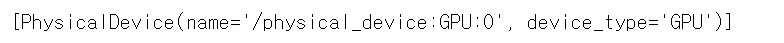

In [39]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

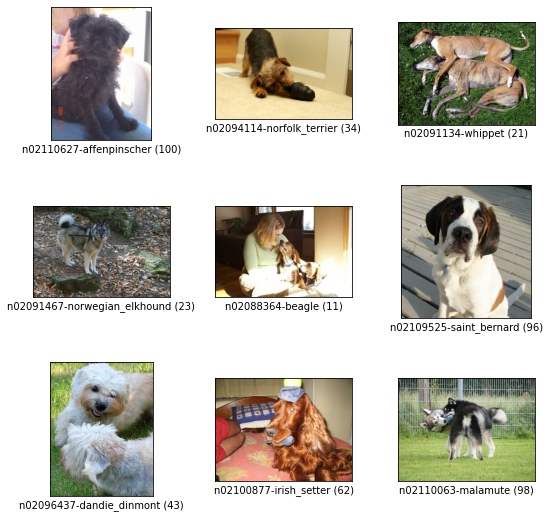

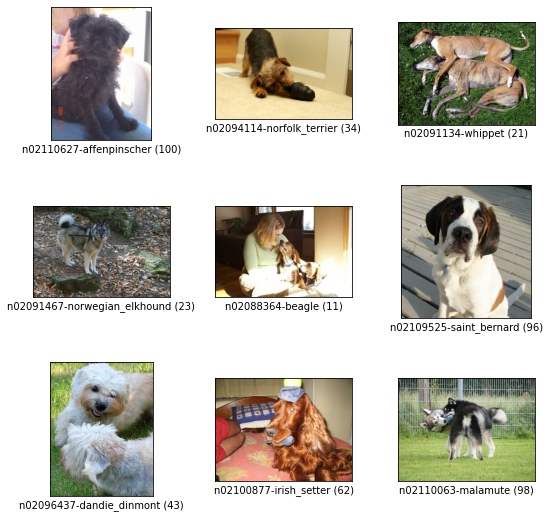

In [40]:
tfds.show_examples(ds_train, ds_info)

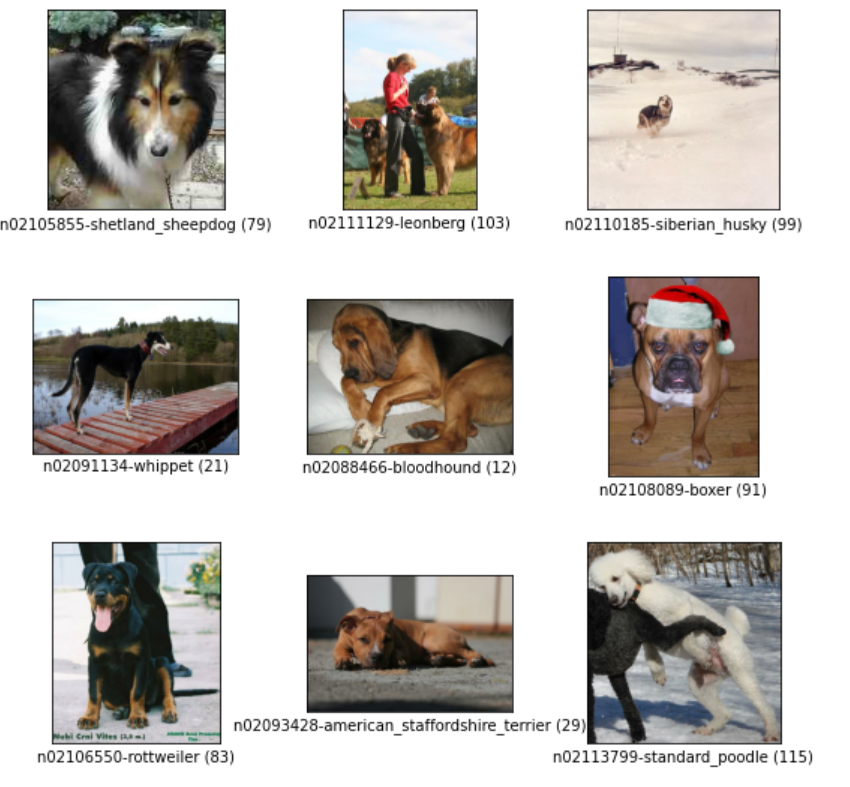

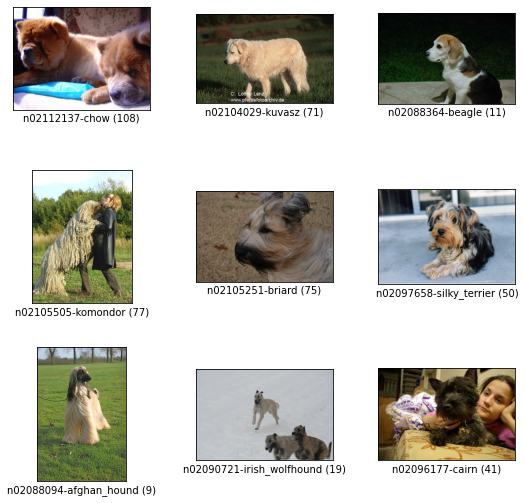

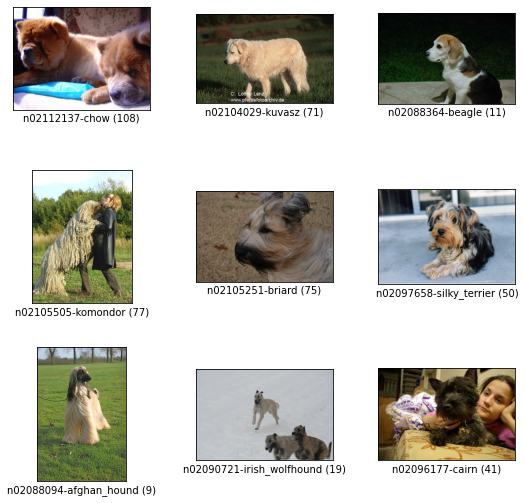

In [41]:
tfds.show_examples(ds_test, ds_info)

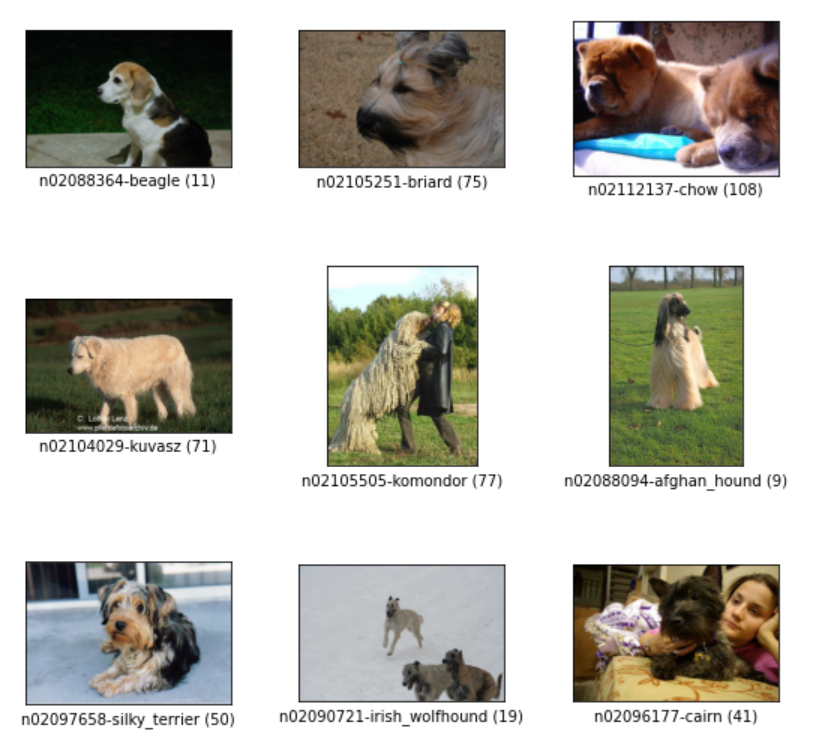

In [42]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

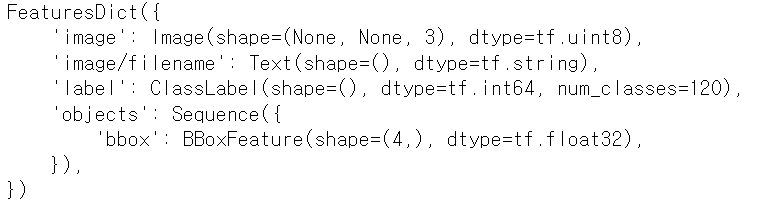

xywh' 는 바운딩박스 중심점을 x, y로 표기하고, 사각형의 너비 w와 높이 h를 표기하는 방법
(x_center, y_center, width, height)
minmax'는 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법
(x_min, x_max, y_min, y_max)

# CAM 구현하기

In [43]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

num_classes = 120

def normalize_and_resize_img(item):
    image = item['image']
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32)/255., item['label']

# 1. ResNet50 베이스 모델 (GAP 제거)
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling=None  # GAP 미적용 → 특성 맵 보존
)

# 2. 수동으로 GAP 및 분류기 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)  # GAP 적용 (특성 맵 → 1D 벡터)
preds = Dense(num_classes, activation='softmax')(x)

# 3. 최종 모델 정의
cam_model = Model(inputs=base_model.input, outputs=preds)


In [44]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    # 이미지 전처리 및 예측
    img_tensor, _ = normalize_and_resize_img(item)
    preds = model.predict(tf.expand_dims(img_tensor, 0))
    class_idx = np.argmax(preds[0])
    
    # 마지막 컨볼루션 레이어 추출
    last_conv_layer = model.layers[0].get_layer('conv5_block3_out')
    cam_submodel = Model(
        inputs=model.input,
        outputs=[last_conv_layer.output, model.output]
    )
    
    # 특성 맵 및 가중치 추출
    conv_outputs, _ = cam_submodel(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0]  # (7,7,2048)
    
    # CAM 계산
    class_weights = model.layers[-1].get_weights()[0][:, class_idx]
    cam_image = np.sum(class_weights * conv_outputs, axis=-1)
    
    # 후처리
    cam_image = np.maximum(cam_image, 0)
    cam_image = cv2.resize(cam_image, (width, height))
    cam_image = (cam_image - np.min(cam_image)) / (np.max(cam_image) - np.min(cam_image) + 1e-8)
    
    return cam_image


In [45]:
cam_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

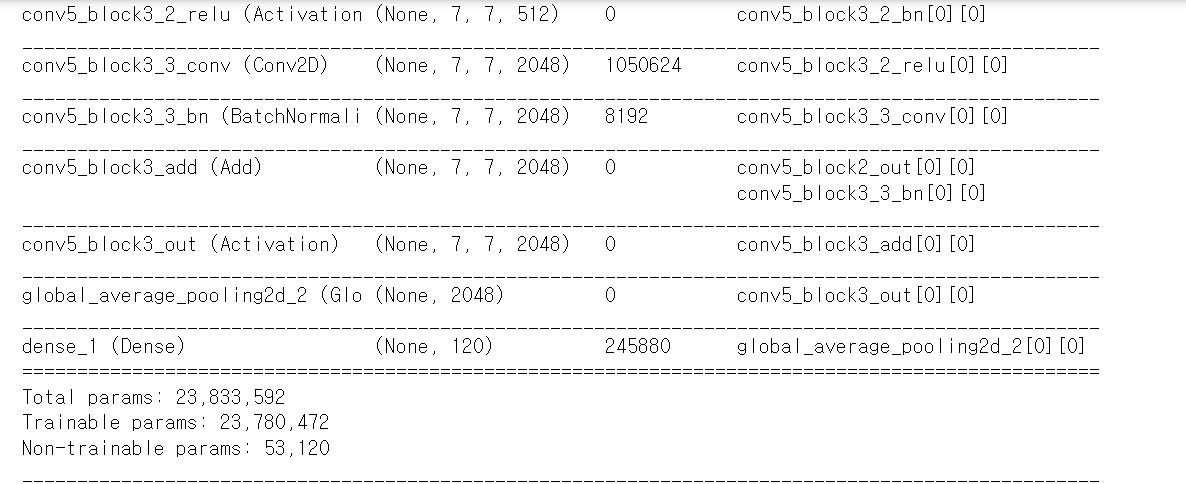

In [46]:
print(np.min(cam_image), np.max(cam_image), np.mean(cam_image))


0.1068401 0.9999242 0.3481966


In [47]:
'''
item = next(iter(ds_test))
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

AttributeError: 'InputLayer' object has no attribute 'get_layer'

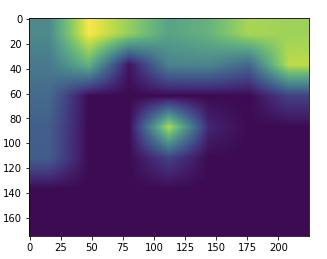

In [48]:
def visualize_cam_on_image(image, cam_image, alpha=0.5):
    # 히트맵 생성
    heatmap = cv2.applyColorMap(np.uint8(255*cam_image), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # 이미지 블렌딩
    blended = cv2.addWeighted(image, 1-alpha, heatmap, alpha, 0)
    return blended


In [49]:
type(item['image'].numpy())

origin_image = item['image'].numpy().astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended = visualize_cam_on_image(origin_image, cam_image_3channel)
plt.imshow(blended_image)

error: OpenCV(4.5.3) /tmp/pip-req-build-agffqapq/opencv/modules/core/src/arithm.cpp:647: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


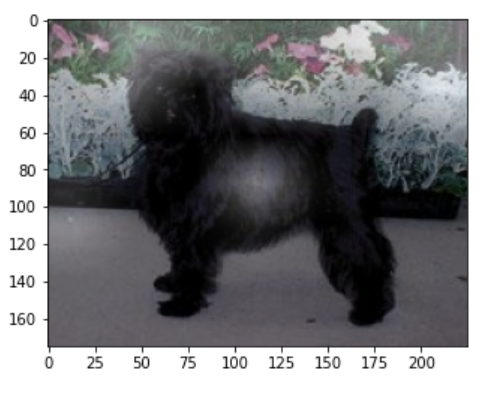

In [50]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    # 이미지 전처리
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad-CAM 서브 모델
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(activation_layer).output, model.output]
    )
    
    # 그래디언트 계산
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        loss = pred[:, class_idx]
        
    grads = tape.gradient(loss, conv_output)[0]
    weights = tf.reduce_mean(grads, axis=(0,1))
    
    # Grad-CAM 계산
    grad_cam = tf.reduce_sum(conv_output[0] * weights, axis=-1)
    grad_cam = np.maximum(grad_cam, 0)
    grad_cam = cv2.resize(grad_cam.numpy(), (width, height))
    grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min() + 1e-8)
    
    return grad_cam


In [51]:
grad_cam_image = generate_cam(cam_model, item)
plt.imshow(grad_cam_image)

AttributeError: 'InputLayer' object has no attribute 'get_layer'

ValueError: operands could not be broadcast together with shapes (325,500,3) (175,225,3) 

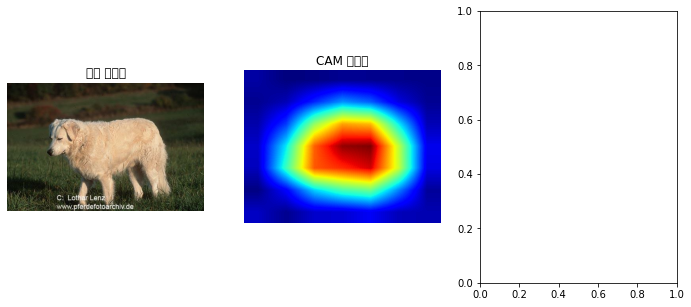

In [52]:
# 원본 이미지 준비
original_image = item['image'].numpy()

# 결과 이미지 나란히 표시
plt.figure(figsize=(12, 5))

# 원본 이미지
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('원본 이미지')
plt.axis('off')

# CAM 히트맵
plt.subplot(1, 3, 2)
plt.imshow(grad_cam_image, cmap='jet')
plt.title('CAM 히트맵')
plt.axis('off')

# 오버레이 이미지
plt.subplot(1, 3, 3)
# CAM을 3채널로 변환
heatmap = np.uint8(255 * grad_cam_image)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 원본과 히트맵 합성 (투명도 0.4)
alpha = 0.4
overlay = np.uint8(original_image * (1-alpha) + heatmap * alpha)
plt.imshow(overlay)
plt.title('오버레이 결과')
plt.axis('off')

plt.tight_layout()
plt.show()


In [53]:
def get_bounding_box(cam_image, threshold=0.5):
    # 이진화
    _, thresh = cv2.threshold(np.uint8(255*cam_image), 
                             int(255*threshold), 
                             255, cv2.THRESH_BINARY)
    
    # 컨투어 추출
    contours, _ = cv2.findContours(thresh, 
                                 cv2.RETR_EXTERNAL, 
                                 cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None
    
    # 최대 영역 찾기
    max_contour = max(contours, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(max_contour)
    return (x, y, x+w, y+h)


In [54]:
def get_iou(gt_bbox, pred_bbox):
    # 교집합 영역 계산
    x1 = max(gt_bbox[0], pred_bbox[0])
    y1 = max(gt_bbox[1], pred_bbox[1])
    x2 = min(gt_bbox[2], pred_bbox[2])
    y2 = min(gt_bbox[3], pred_bbox[3])
    
    inter_area = max(0, x2-x1) * max(0, y2-y1)
    
    # 각 영역 계산
    gt_area = (gt_bbox[2]-gt_bbox[0])*(gt_bbox[3]-gt_bbox[1])
    pred_area = (pred_bbox[2]-pred_bbox[0])*(pred_bbox[3]-pred_bbox[1])
    
    # IoU 계산
    union_area = gt_area + pred_area - inter_area
    return inter_area / union_area if union_area != 0 else 0


In [55]:
# 데이터 준비
item = next(iter(ds_test))
origin_image = item['image'].numpy().astype(np.uint8)

# CAM 생성
cam_image = generate_cam(cam_model, item)

# Grad-CAM 생성
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

# 바운딩 박스 추출
cam_bbox = get_bounding_box(cam_image)
gradcam_bbox = get_bounding_box(grad_cam_image)

# 시각화
fig, ax = plt.subplots(2, 3, figsize=(20,10))

# 원본 이미지
ax[0,0].imshow(origin_image)
ax[0,0].set_title('Original Image')

# CAM 결과
ax[0,1].imshow(visualize_cam_on_image(origin_image, cam_image))
ax[0,1].set_title('CAM')

# Grad-CAM 결과
ax[0,2].imshow(visualize_cam_on_image(origin_image, grad_cam_image))
ax[0,2].set_title('Grad-CAM')

# 바운딩 박스 시각화
def draw_bbox(image, bbox, color):
    image = image.copy()
    if bbox:
        cv2.rectangle(image, (bbox[0],bbox[1]), (bbox[2],bbox[3]), color, 2)
    return image

ax[1,0].imshow(draw_bbox(origin_image, cam_bbox, (0,255,0)))
ax[1,0].set_title('CAM BBox')

ax[1,1].imshow(draw_bbox(origin_image, gradcam_bbox, (255,0,0)))
ax[1,1].set_title('Grad-CAM BBox')

# IoU 계산 (가상의 GT 박스)
gt_bbox = [100, 80, 300, 250]  # 예시 값
ax[1,2].imshow(draw_bbox(origin_image, gt_bbox, (0,0,255)))
ax[1,2].set_title(f'IoU: CAM={get_iou(gt_bbox,cam_bbox):.2f}, Grad-CAM={get_iou(gt_bbox,gradcam_bbox):.2f}')

plt.tight_layout()
plt.show()


AttributeError: 'InputLayer' object has no attribute 'get_layer'

In [ ]:
bbox1 = [50, 50, 150, 150]
bbox2 = [100, 100, 200, 200]
print(get_iou(bbox1, bbox2))  # Output: 0.14285714285714285


In [ ]:
bbox1 = [50, 50, 150, 150]
bbox2 = [100, 100, 200, 200]
print(get_iou(bbox1, bbox2))  # Output: 0.14285714285714285
